# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

<p>
In this stage, consider the following questions:
<p>

1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

3.   **How would you proceed?**


1. We are being asked to create a random forest machine learning model that can predict whether a tiktok is considered a claim or an opinion. Given this is a binary classification model, we will use our standard binary classification metrics: precision, recall, accuracy, F1, and F-beta. We should not additionally that recall is going to be a more important evaluation metrics because it is more important to minimize false negatives. We have come to this conclusion not only because reviewing claims is more important than opinions, but also our previous reports have concluded that tiktoks identified as making claims have much larger engagement than opinions.
<p>
2. Since this model will be evaluating whether content is a terms of service violation, it is important to significantly minimize false positives and false negatives, since we neither want acceptable content censored nor unacceptable content to disperse. However, we will be extra careful to catch false negatives.
<p>
3. The dataset has about 20,000 tiktoks so we should feel confident proceeding with a split of the data which includes a validation set as well as the test and training sets. We can then perform a cross-fold validation to determine a more optimal model. We will split the data into train/validation/test proportions: (60/20/20), fit our random tree models to their respective boostrapped samples of the training data, and use the validation set to tune our hyperparameters. We evaluate our models using the above metrics, choose a the best performing champion model, and finally evaluate its predictive power on the testing set.

### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance

Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [6]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [7]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [8]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [9]:
# Drop rows with missing values
data = data.dropna(axis=0)
data.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [10]:
# Display first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [11]:
# Check for duplicates
data.duplicated().sum()

0

Check for and handle outliers.

Tree models are robust to negative impacts by outliers.

Check class balance.

In [12]:
# Check class balance
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**


### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [13]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].str.len()

Calculate the average text_length for claims and opinions.

In [14]:
# Calculate the average text_length for claims and opinions
data.groupby('claim_status')['text_length'].mean()

claim_status
claim      95.376978
opinion    82.722562
Name: text_length, dtype: float64

Visualize the distribution of `text_length` for claims and opinions.

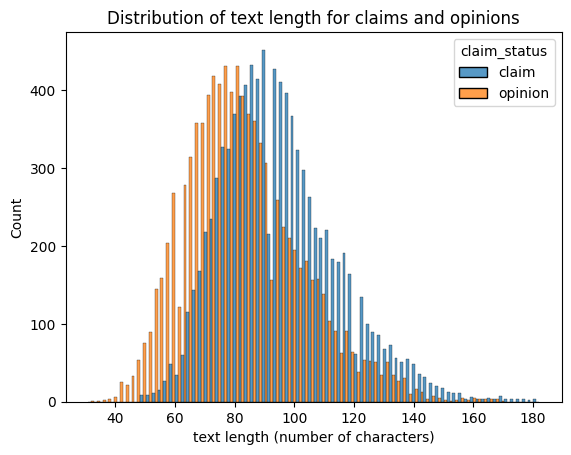

In [15]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
sns.histplot(data, stat= 'count', x= 'text_length', legend = True, hue = 'claim_status', multiple = 'dodge')
plt.xlabel("text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of text length for claims and opinions")

plt.show()

**Feature selection and transformation**

Encode target and catgorical variables.

In [16]:
# Create a copy of the X data
# Drop unnecessary columns
X = data.drop(['#','video_id','video_transcription_text'], axis=1)

# Encode target variable
X['claim_status'] = X['claim_status'].replace({'claim':1, 'opinion':0})

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns = ['verified_status', 'author_ban_status'], drop_first = True)
X.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [17]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [18]:
# Isolate features
X = X.drop('claim_status', axis = 1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [20]:
# Split the training data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [21]:
# Get shape of each training, validation, and testing set
X_test.shape, y_test.shape, X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((3817, 10), (3817,), (11450, 10), (3817, 10), (11450,), (3817,))

### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [22]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'n_estimators': [75,100,200],
            'max_depth': [5,7,None],
            'min_samples_leaf': [1,2],
            'min_samples_split': [2,3],
            'max_features': [.3,.6],
            'max_samples': [.7]}

# Define a list of scoring metrics to capture
scoring = ['precision', 'recall', 'accuracy', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit = 'recall')

In [23]:
%%time
rf_cv.fit(X_tr, y_tr)

CPU times: user 5min 39s, sys: 714 ms, total: 5min 40s
Wall time: 5min 40s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['precision', 'recall', 'accuracy', 'f1'])

In [24]:
# Examine best recall score
rf_cv.best_score_

0.9908534395531852

In [25]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

Check the precision score to make sure the model isn't labeling everything as claims. You can do this by using the `cv_results_` attribute of the fit `GridSearchCV` object, which returns a numpy array that can be converted to a pandas dataframe. Then, examine the `mean_test_precision` column of this dataframe at the index containing the results from the best model. This index can be accessed by using the `best_index_` attribute of the fit `GridSearchCV` object.

In [26]:
# Access the GridSearch results and convert it to a pandas df
rf_results_df = pd.DataFrame(rf_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
print(rf_results_df['mean_test_precision'][rf_cv.best_index_])
print(rf_results_df['mean_test_recall'][rf_cv.best_index_])

0.9994785483051682
0.9908534395531852


**Question:** How well is your model performing? Consider average recall score and precision score. <p>
The model is performing exceptionally with average recall and precision at greater than 99% on the test data. So it rarely misses a positive that should've been recognized and the reliability of a positive recognition is also incredibly strong.

### **Build an XGBoost model**

In [27]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3,6,9],
            'min_child_weight': [3,5],
            'learning_rate': [.01, .1],
            'n_estimators': [300, 500]}

# Define a list of scoring metrics to capture
scoring = ['precision', 'recall', 'accuracy', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'recall')

In [28]:
%%time
xgb_cv = xgb_cv.fit(X_tr, y_tr)

CPU times: user 1min 1s, sys: 1.14 s, total: 1min 2s
Wall time: 32.3 s


In [29]:
# Examine best recall score
xgb_cv.best_score_

0.9898176171763818

In [30]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 300}

Repeat the steps used for random forest to examine the precision score of the best model identified in the grid search.

In [31]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
print(xgb_results_df['mean_test_precision'][xgb_cv.best_index_])
print(xgb_results_df['mean_test_recall'][xgb_cv.best_index_])

0.9989540877965151
0.9898176171763818


**Question:** How well does your model perform? Consider recall score and precision score. <p>
Again we have that for both average recall and precision this model is also performing exceptionally. The averages still being about 99% for both recall and precision scores.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [32]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the validation set.

In [33]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Display the true labels of the validation set.

In [34]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

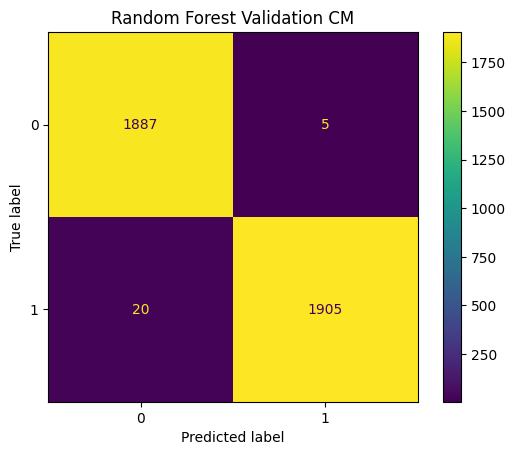

In [35]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels = None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random Forest Validation CM')
plt.show()

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.
<br> </br>

**Note:** In other labs there was a custom-written function to extract the accuracy, precision, recall, and F<sub>1</sub> scores from the GridSearchCV report and display them in a table. You can also use scikit-learn's built-in [`classification_report()`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) function to obtain a similar table of results.

In [36]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names = target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** What does your classification report show? What does the confusion matrix indicate? <p>
The classification report shows the model had near perfect recall, precision, and accuracy. The confusion matrix indicates the same, with single digit errors for opinion classification and only 20 error for claim classification.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [37]:
# Use the best estimator to predict on the validation data
y_pred = xgb_cv.best_estimator_.predict(X_val)

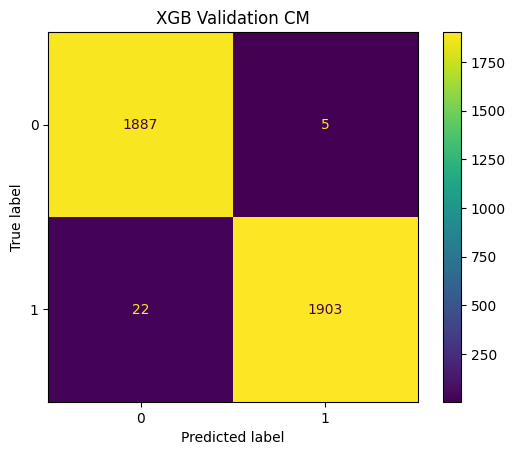

In [38]:
# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = None)

# Plot confusion matrix
disp.plot()

# Display plot
plt.title('XGB Validation CM')
plt.show()

In [39]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names = target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model? <p>
The XGBoost model also has a fantastic performance to the point where the choice between models is negligible, but since the random forest model performs very slightly better at identifying claims, it will be our champion model.

### **Use champion model to predict on test data**

In [40]:
y_pred = rf_cv.best_estimator_.predict(X_test)

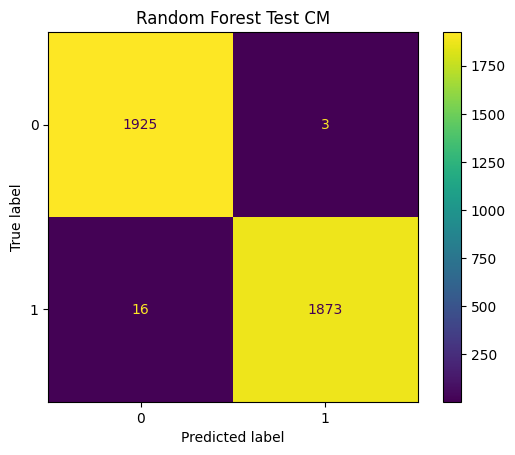

In [41]:
# Compute values for confusion matrix
test_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = None)

# Plot confusion matrix
test_disp.plot()

# Display plot
plt.title('Random Forest Test CM')
plt.show()

#### **Feature importances of champion model**


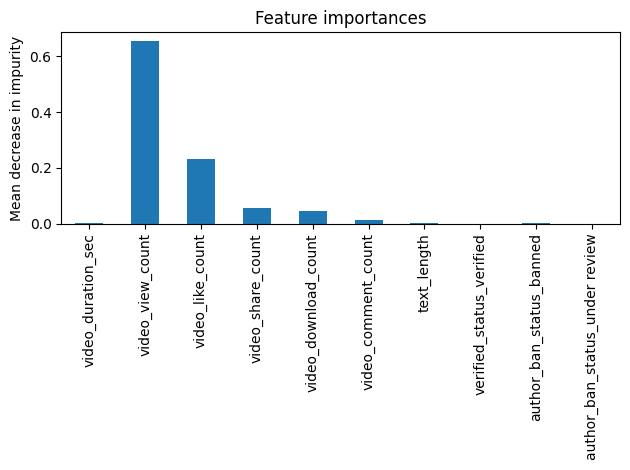

In [42]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Question:** Describe your most predictive features. Were your results surprising? <p>
We found that video_view_count and video_like_count were, by far, the most important features towards predicting claim_status. This is not surprising at all considering our previous analyses which showed the median view/like counts of claims being roughly 10x greater than opinions.

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


1. The champion random forest model was excellent at predicting claim_status, evidenced by the recall/precision scores greater than .99, so towards the goal of classifying tiktoks as claims or opinions the model is a great choice. 
<p>
2. The 2 most important features were clearly video_view_count and video_like_count, followed by video_share_count and video_download_count, so our model almost entirely used these 4 features in the prediction of claim_status. 
<p>
3. Any performance enhancing would be negligible given the fantastic model performance already. Further feature investigation towards a better model would be a waste of time. 
<p>
4. The model requires no additional features. If we were to spend the time enhancing our already almost perfect metrics, then we could add information about reporting, such as number of reports on each tiktok or number of lifetime reports for the author's account.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.